In [1]:
import torch.cuda
from torch.optim import Adam

from datasets.ner_dataset import NerDataset
from models.bert_crf import BertCRF
from re_utils.common import dict_to_device
from tqdm import tqdm
from typing import List
from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

In [2]:
num_labels = 17
bert_name = "sberbank-ai/ruBert-base"
train_tokenized_texts_path = "resources/data/train/tokenized_texts.jsonl"
test_tokenized_texts_path = "resources/data/test/tokenized_texts.jsonl"
dropout = 0.2
batch_size = 16
epochs = 10
log_every = 20
lr=5e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def draw_plots(loss_history: List[float], f1: List[float]):
    display.clear_output(wait=True)

    f, (ax1, ax2) = plt.subplots(2)
    f.set_figwidth(15)
    f.set_figheight(10)

    ax1.set_title("training loss")
    ax2.set_title("f1 micro")

    ax1.plot(loss_history)
    ax2.plot(f1)

    plt.show()

    if len(loss_history) > 0:
        print(f"Current loss: {loss_history[-1]}")
    if len(f1) > 0:
        print(f"Current f1: {f1[-1]}")

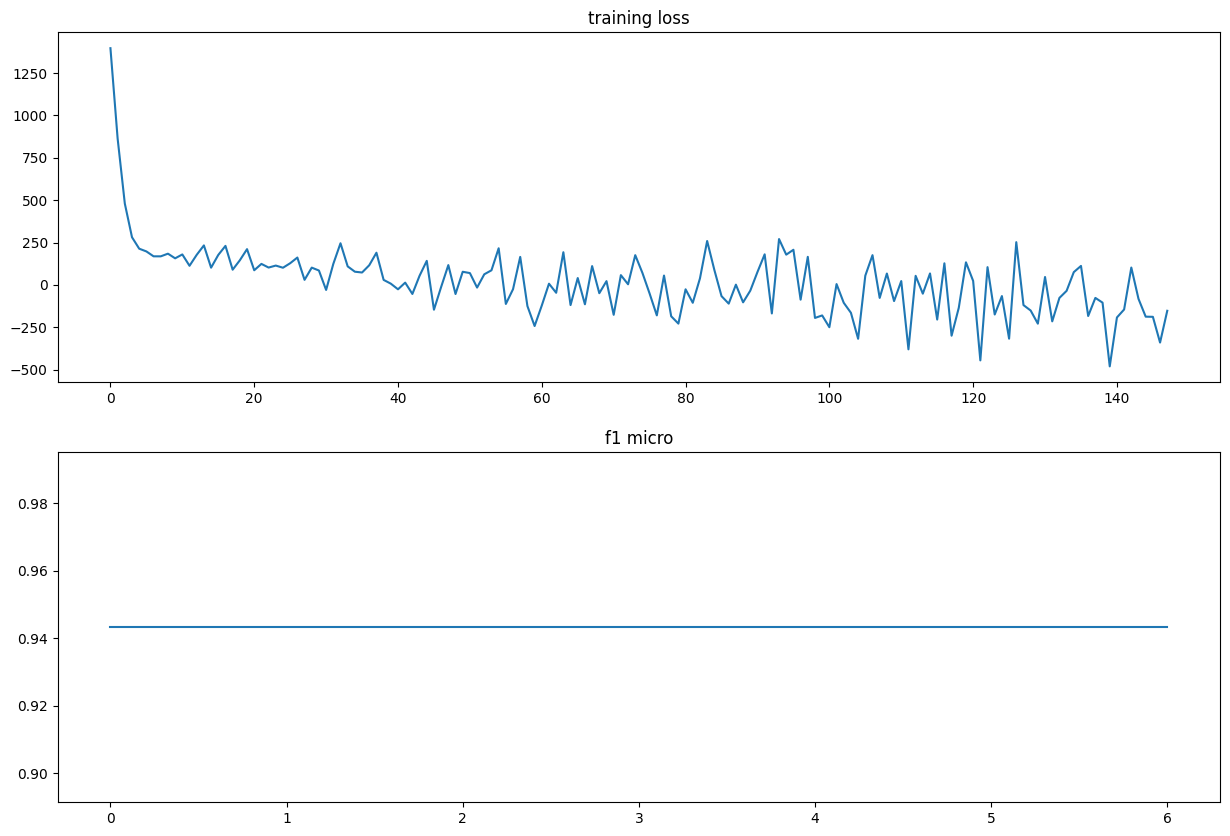

 55%|███████████████████████▋                   | 32/58 [00:27<00:20,  1.28it/s]

Current loss: -152.79110717773438
Current f1: 0.9432009141628016
Epoch 3/10


In [ ]:
from torch.utils.data import DataLoader

model = BertCRF(num_labels, bert_name, dropout)
model = model.to(device)
model.train()

train_dataset = NerDataset(train_tokenized_texts_path)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_function)

test_dataset = NerDataset(test_tokenized_texts_path)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_function)

optimizer = Adam(model.parameters(), lr=lr)

loss_history = []
f1 = []

step = 0
for epoch in range(1, epochs):
    for batch in tqdm(train_data_loader):
        step += 1

        model.zero_grad()

        batch = dict_to_device(batch, device)
        loss = model(**batch)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if step % log_every == 0:
            model.eval()
            predictions = []
            ground_truth = []
            with torch.no_grad():
                for batch in test_data_loader:
                    labels = batch["labels"]
                    del batch["labels"]
                    batch = dict_to_device(batch)
                    prediction = model.decode(**batch)

                    flatten_prediction = [item for sublist in prediction for item in sublist]
                    flatten_labels = torch.masked_select(labels, batch["attention_mask"].bool()).tolist()
                    
                    predictions.extend(flatten_prediction)
                    ground_truth.extend(flatten_labels)
            f1_micro = f1_score(ground_truth, predictions, average="micro")
            f1.append(f1_micro)
            model.train()
        
        draw_plots(loss_history, f1)
        print(f"Epoch {epoch}/{epochs}")